In [1]:
import math
import pandas as pd
import numpy as np
import random
import time

from sklearn.model_selection import KFold
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.utils._testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold

import scipy.signal as signal

%matplotlib inline
from Regression_compressive_sensing import *

#### Load/Read the images; plot (“imshow”) the images

(200, 192)


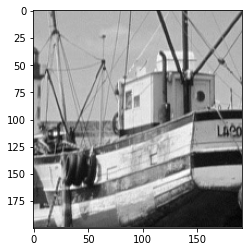

In [2]:
imgBoat = imgRead('fishing_boat.bmp')
print(imgBoat.shape)
imgShow(imgBoat)

(512, 640)


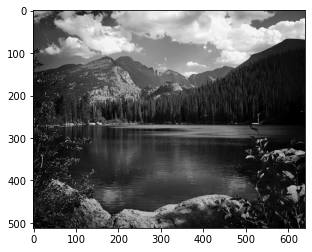

In [3]:
imgNature = imgRead('nature.bmp')
imgShow(imgNature)
print(imgNature.shape)

#### Define K = 8, numSample = 30

In [21]:
K = 8
numSample = 30

#### select a desired KxK block from an image

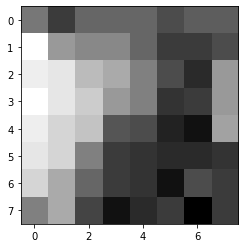

In [22]:
list_blks = divideBlock(imgNature, K)

boat_block_1 = list_blks[0][0]
imgShow(boat_block_1)

#### sample 30 pixels from a block (to simulate a compressed sensed or corrupted image)

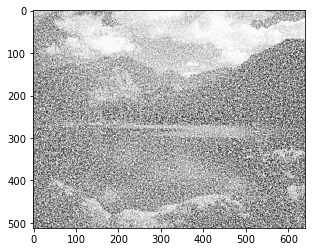

In [23]:
list_samples = samplingBlocksInList(list_blks, numSample)
imgShow(putBlocksTogether(list_samples))

In [24]:
sampledBlock_1 = list_samples[0][0]
T = calcTransMatrix(K)

In [25]:
blockIn = sampledBlock_1
print(blockIn)
K = blockIn.shape[0]
T = calcTransMatrix(K)
    
list_sample_idx = []
blockIn = blockIn.flatten()
for i in range(blockIn.shape[0]):
    if blockIn[i] != -1:
        list_sample_idx.append(i)
    
A = T[list_sample_idx]
B = blockIn[blockIn!=-1]

print(len(list_sample_idx), B.shape)

[[ -1.  -1.  -1.  -1. 160. 157.  -1. 159.]
 [ -1.  -1. 164.  -1. 160. 155.  -1. 157.]
 [176. 175.  -1.  -1. 163. 157.  -1. 166.]
 [ -1.  -1.  -1.  -1.  -1. 154.  -1.  -1.]
 [ -1.  -1.  -1. 158.  -1. 152.  -1. 167.]
 [175.  -1.  -1.  -1. 154. 153.  -1. 154.]
 [173. 168.  -1.  -1. 154.  -1. 157. 155.]
 [ -1.  -1. 156.  -1. 153. 155. 148. 155.]]
30 (30,)


#### use sklearn.linear_model.Lasso regression to estimate DCT coefficients with lambda=0.01

In [26]:
from sklearn.linear_model import Lasso
reg = Lasso(alpha=0.01).fit(A,B)
print("DCT coef:",reg.coef_)

DCT coef: [  0.          35.86588656  22.16438726  -0.           5.68225773
  -0.          -0.           0.          10.71522146  -1.36172013
  -0.          -0.69098795   0.          -3.00651791  -0.
   6.3963274   -5.21047954   0.         -12.06181267   0.
  -0.           0.           0.          -6.12555935   0.
  -0.           0.           0.          -0.           7.72435384
  -0.           1.40281324  -6.0443584   -6.88248058   0.
  -3.14644656   0.          -0.           0.36501979  -0.
   1.49278835   0.          -0.           2.62274214  -2.54064394
   0.          -0.           0.           0.           0.
  -0.           0.           0.88336284  -3.07273742   0.
  -0.          10.56714227  -1.59744729   3.04377415  -4.00534583
   0.          -1.05052863  -0.           0.        ]


#### Construct a list of 20 lambda's from 1e-6 to 1e6

In [27]:
import numpy as np
import pandas as pd
from collections import defaultdict
import matplotlib.pyplot as plt

lambda_list = np.logspace(-6, 6, 20, endpoint = True)
coef_dict = defaultdict(list)

for lam in lambda_list:
    E_MSE = nRep_CV_Regression_analysis (A, B, Lasso(alpha=lam, fit_intercept = False))
    coef_dict['lambdas'].append(lam)
    coef_dict['E_MSE'].append(E_MSE)

df = pd.DataFrame(coef_dict)
df = df.sort_values(by = "E_MSE")
df

lambdas         E_MSE
0         0.000001     23.600087
3         0.000078     27.596526
2         0.000018     31.234135
4         0.000336     31.956655
1         0.000004     32.255485
6         0.006158     33.273332
5         0.001438     34.406233
7         0.026367     42.430919
8         0.112884     48.660778
9         0.483293     78.283384
10        2.069138    332.885985
11        8.858668   5080.671810
12       37.926902  25548.533333
13      162.377674  25548.533333
18   233572.146909  25548.533333
16    12742.749857  25548.533333
19  1000000.000000  25548.533333
14      695.192796  25548.533333
15     2976.351442  25548.533333
17    54555.947812  25548.533333

finished in 0.24548578262329102 seconds
[[169. 166. 162. 158. 160. 157. 154. 159.]
 [171. 172. 164. 158. 160. 155. 150. 157.]
 [176. 175. 162. 161. 163. 157. 155. 166.]
 [173. 170. 157. 158. 159. 154. 157. 171.]
 [173. 162. 157. 158. 152. 152. 154. 167.]
 [175. 164. 156. 154. 154. 153. 154. 154.]
 [173. 168. 156. 153. 154. 153. 157. 155.]
 [166. 163. 156. 151. 153. 155. 148. 155.]]
[[162 155 160 160 160 157 159 159]
 [178 166 164 164 160 155 155 157]
 [176 175 170 168 163 157 153 166]
 [178 175 172 166 163 154 155 166]
 [176 173 171 158 157 152 150 167]
 [175 173 163 155 154 153 153 154]
 [173 168 160 155 154 150 157 155]
 [163 168 156 150 153 155 148 155]]


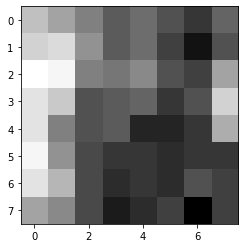

In [28]:
start_time = time.time()

recovered_block_1 = recoverOneBlock(sampledBlock_1)
print("finished in %s seconds" % (time.time() - start_time))


imgShow(recovered_block_1)
print(recovered_block_1)
print(boat_block_1)

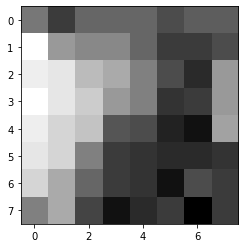

In [29]:
imgShow(boat_block_1)

### Recover all blocks

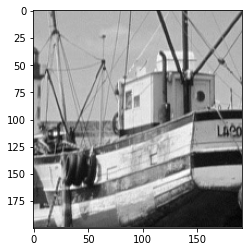

In [13]:
imgShow(imgBoat)

finished in 166.78157138824463 seconds
(200, 192)


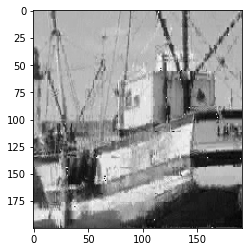

In [14]:
start_time = time.time()
BoatRecover = imgRecover(imgBoat, 8, 20)
print("finished in %s seconds" % (time.time() - start_time))

print(BoatRecover.shape)
imgShow(BoatRecover)

In [5]:
start_time = time.time()
NatureRecover = imgRecover(imgNature, 16, 100)
print("finished in %s seconds" % (time.time() - start_time))

print(NatureRecover.shape)
imgShow(NatureRecover)


KeyboardInterrupt: 

In [6]:
print(mean_squared_error(NatureRecover, imgNature))

291.4613952636719
